## Notebook extensions

Allows for real-time modules' code update

In [3]:
%load_ext autoreload

In [4]:
%autoreload 2

## Prerequisites

The libraries that are needed in order for the project to work

In [5]:
import numpy as np # Working with tensors

In [6]:
import sounddevice # Recording audio

In [7]:
import matplotlib.pyplot as plt # Data visualization

In [8]:
import seaborn as sns # For easier visualization in certain places

In [9]:
import os # Managing dataset files

In [10]:
import librosa # Audio processing

In [11]:
import pandas as pd # For dataframes

In [12]:
import tensorflow as tf # NN framework

2024-12-05 16:17:19.294712: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733404639.359081    3485 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733404639.378283    3485 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 16:17:19.522751: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
import keras.layers

In [14]:
from tqdm.notebook import tqdm # Progress bars

In [15]:
import sklearn # Contains useful utilities for working with the model

In [16]:
import audiomentations # Audio augmentations

In [17]:
from IPython.display import Audio # For an audio widget inside of the notebook

In [18]:
from types import MappingProxyType # Immutable dictionary

In [19]:
import scipy # Contains signal filters

In [20]:
import soundfile as sf

In [21]:
import sys # To import modules of the parent folder

## Custom modules

In [22]:
sys.path.append('../')
from config import Config # Configuration variables
import processing

## Dataset-related constants

In [23]:
STR_TO_EMOTION = MappingProxyType({
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised',
})

STR_TO_INTENSITY = MappingProxyType({
    '01': 'normal',
    '02': 'strong',
})

def get_speaker_gender(str):
    return 'female' if int(str) % 2 == 0  else 'male'

## Configuration

In [24]:
cfg = Config() # Values inside config.py are used by default

## Dataset preprocessing

"The Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS)" by Livingstone & Russo is licensed under CC BY-NA-SC 4.0.

> The dataset has been downloaded as a .zip archive from
>
>
> https://github.com/HLTSingapore/Emotional-Speech-Data
>
>
> Folders Actor 1 ... 24 were then unpacked to the `./research/dataset/RAVDESS` directory of the project

> Dataset below is not yet implemented 

Kun Zhou, Berrak Sisman, Rui Liu and Haizhou Li, "Seen and unseen emotional style transfer for voice conversion with a new emotional speech dataset" ICASSP 2021-2021 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)

> The dataset has been downloaded as a .zip archive from
>
>
> https://github.com/HLTSingapore/Emotional-Speech-Data
>
>
> Folders 0001...0020 were then unpacked to the `./research/dataset/ESD` directory of the project

### Loading the information

In [25]:
dataset_information = pd.DataFrame(columns=['filepath', 'gender', 'emotion', 'intensity'])

In [26]:
for dirname, _, filenames in os.walk('./dataset/RAVDESS'):
    for filename in filenames:
        if filename == '.gitignore': continue
        params = filename[:-4].split('-')
        dataset_information.loc[len(dataset_information)] = [os.path.join(dirname, filename), 
                                                             get_speaker_gender(dirname[-2:]), 
                                                             STR_TO_EMOTION[params[2]], 
                                                             STR_TO_INTENSITY[params[3]]]

In [27]:
dataset_information.sample(5)

,filepath,gender,emotion,intensity
619,./dataset/RAVDESS/Actor_20/03-01-02-01-01-01-2...,female,calm,normal
1150,./dataset/RAVDESS/Actor_10/03-01-04-02-01-01-1...,female,sad,strong
172,./dataset/RAVDESS/Actor_16/03-01-01-01-02-02-1...,female,neutral,normal
1042,./dataset/RAVDESS/Actor_22/03-01-07-02-02-02-2...,female,disgust,strong
64,./dataset/RAVDESS/Actor_07/03-01-05-01-01-01-0...,male,angry,normal


Checking if the dataset is balanced across the classes:

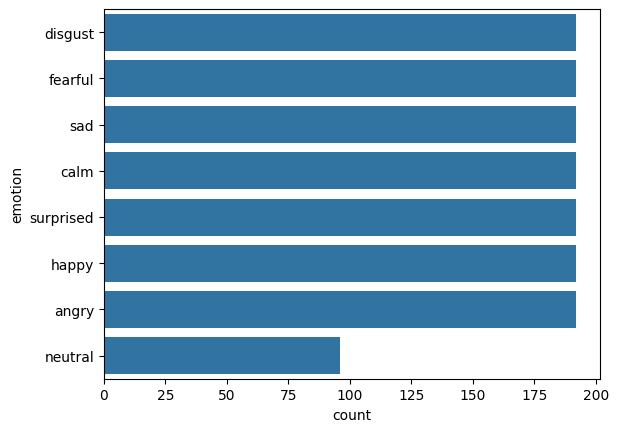

In [28]:
_ = sns.countplot(dataset_information['emotion']) # How many samples of each emotion are there

> Neutral emotion has half the samples since it does not have an intense expression, so some kind of dataset balancing is required

### Processing functions

In [45]:
def preprocess(data, cfg, original_sr):
    result = librosa.resample(data, orig_sr=original_sr, target_sr=cfg.sr)
    
    mask = []
    cutoff_value = 0.002 # To remove empty parts of the recordings

    result_abs = pd.Series(result).apply(np.abs)
    result_abs_mean = result_abs.rolling(window=int(cfg.sr / 10), min_periods=1, center=True).mean()
    
    for mean in result_abs_mean:
        if mean > cutoff_value:
            mask.append(True)
        else:
            mask.append(False)
    
    result = np.array(pd.Series(result)[mask])

    if len(result) < cfg.input_size: return None
    
    result = librosa.effects.preemphasis(result)    
    
    b, a = scipy.signal.butter(5, 25 / cfg.sr, 'high') # A highpass filter with 20Hz cutoff frequency 
    result = scipy.signal.filtfilt(b, a, result, method='gust', axis=0) # Gust method works better than the default one

    res_max = np.abs(result).max()
    result = (result) / (res_max)
    
    return result

### Observing the data

In [46]:
unique_label_samples = dataset_information.drop_duplicates(subset=['gender', 'emotion', 'intensity'])
unique_label_samples.sample(2)

,filepath,gender,emotion,intensity
19,./dataset/RAVDESS/Actor_15/03-01-08-01-01-01-1...,male,surprised,normal
128,./dataset/RAVDESS/Actor_16/03-01-04-02-02-02-1...,female,sad,strong


In [47]:
def make_plots(title, cfg, data):
    fig, ax = plt.subplots(nrows=1, ncols=3)
    
    fig.suptitle(title)
    fig.set_size_inches(10, 2.5)
    
    ax[0].set(title='Time-ampitude')
    ax[1].set(title='Mel')
    ax[2].set(title='MFCC')

    feature_mel = librosa.feature.melspectrogram(y=data, sr=cfg.sr, n_fft=cfg.n_fft, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
    feature_mfcc = librosa.feature.mfcc(y=data, sr=cfg.sr, n_fft=cfg.n_fft, n_mfcc=cfg.n_mfcc, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
    
    time_amplitude = librosa.display.waveshow(y=data, sr=sr, ax=ax[0], color='purple', transpose = False) # Color is explicitly specified to avoid librosa's bug    
    mel = librosa.display.specshow(data=librosa.power_to_db(feature_mel), sr=cfg.sr, ax=ax[1], x_axis='time', y_axis='mel')
    mfcc = librosa.display.specshow(data=feature_mfcc, sr=sr, ax=ax[2], x_axis='time')
    
    fig.tight_layout()

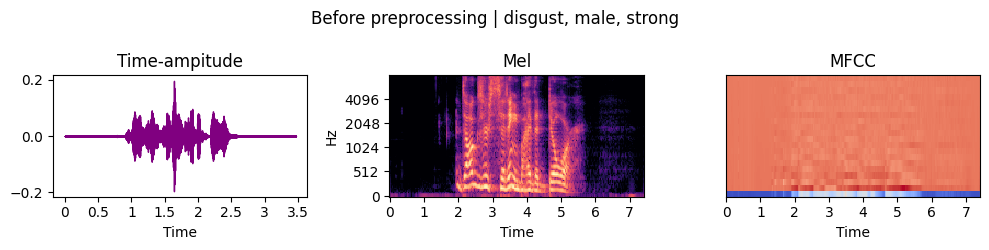

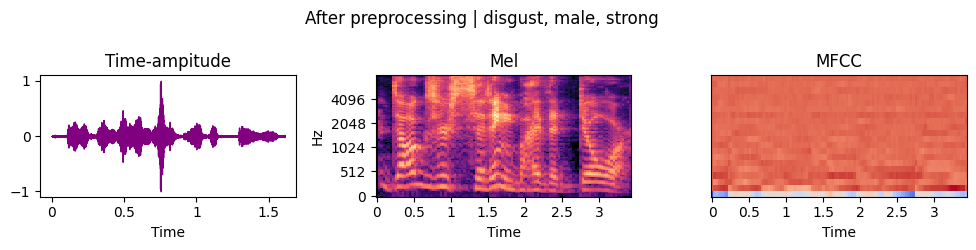

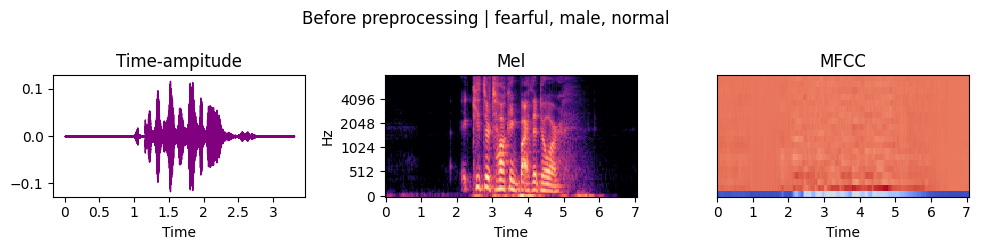

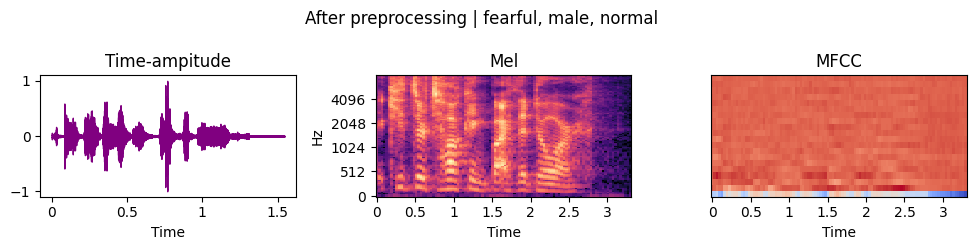

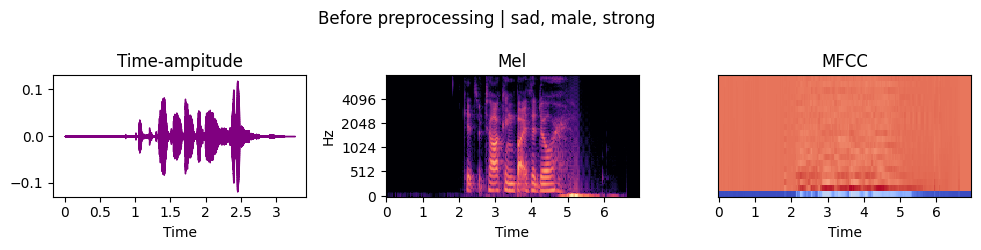

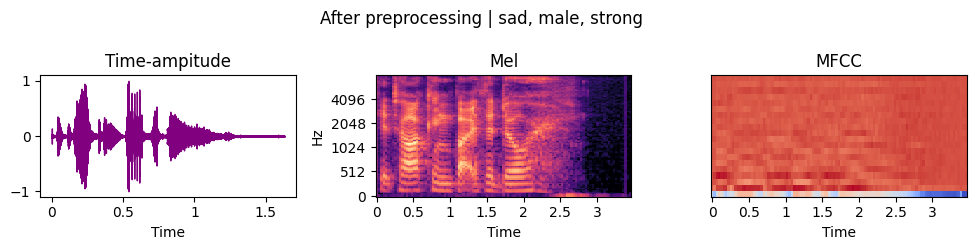

In [48]:
stop_after = 3

for index, sample in unique_label_samples.iterrows():
    stop_after -= 1
    if stop_after < 0: break

    data, sr = librosa.load(sample.filepath, sr=cfg.sr)    
    make_plots(f'Before preprocessing | {sample.emotion}, {sample.gender}, {sample.intensity}', cfg, data)
    make_plots(f'After preprocessing | {sample.emotion}, {sample.gender}, {sample.intensity}', cfg, preprocess(data, cfg, cfg.sr))

In [37]:
listen_sample_data, _ = librosa.load(dataset_information.sample(1).iloc[0].filepath, sr=cfg.sr)

In [38]:
Audio(listen_sample_data, rate=cfg.sr) # Before preprocessing

In [39]:
Audio(preprocess(listen_sample_data, cfg, cfg.sr), rate=cfg.sr) # After preprocessing

### Class balancing

In [467]:
dataset_already_processed = len(os.listdir('processed')) != 0

In [468]:
class_distribution = pd.Series(index=STR_TO_EMOTION.values(), data=[0]*len(STR_TO_EMOTION.values()))

In [469]:
samples = dict(zip(STR_TO_EMOTION.values(), [[], [], [], [], [], [], [], []]))

In [470]:
if not dataset_already_processed:
    for _, sample in tqdm(dataset_information.iterrows(), total=dataset_information.shape[0], desc='Loading and preprocessing the dataset now'):
        data, sr = librosa.load(sample.filepath, sr=cfg.sr)
        data = preprocess(data, cfg, original_sr=cfg.sr)
        
        if data is not None:
            class_distribution[sample.emotion] += len(data)
            samples[sample.emotion].append(data)

Loading and preprocessing the dataset now:   0%|          | 0/1440 [00:00<?, ?it/s]

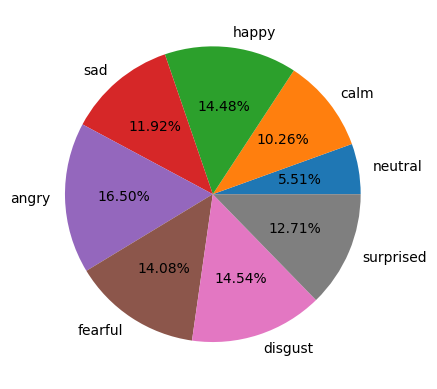

In [471]:
if not dataset_already_processed:
    _ = plt.pie(class_distribution, labels=class_distribution.index, autopct='%.2f%%')

> To balance the classes out random sampling will be performed using inverse distribution. Different augmentations will be picked out at random, and more diverse augmentations are to be applied to less common labels across the preprocessed data.

In [472]:
rebalance_coefficients = class_distribution.max() / class_distribution
print(rebalance_coefficients)

neutral      2.991918
calm         1.608602
happy        1.139226
sad          1.384104
angry        1.000000
fearful      1.171980
disgust      1.134433
surprised    1.298523
dtype: float64


### Data Augmentation

> Impulse Responses from  https://mcdermottlab.mit.edu/Reverb/IR_Survey.html
> 
> Should be copied under the directory of `./research/impulse_responses`

In [473]:
augment = audiomentations.Compose([
    audiomentations.RepeatPart(mode='replace', p=1.0),
    audiomentations.PitchShift(min_semitones=-1, max_semitones=1, p=1.0),
    audiomentations.AddGaussianNoise(min_amplitude=0.0005, max_amplitude=0.001, p=1.0),
    audiomentations.AddColorNoise(p=1.0),
    audiomentations.ApplyImpulseResponse(ir_path='impulse_responses', p=1.0),
])

In [474]:
Audio(augment(samples=np.array(samples['neutral'][0]), sample_rate=cfg.sr), rate=cfg.sr) # Augmentation playground

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/transforms_interface.py:62: UserWarning: Warning: input samples dtype is np.float64. Converting to np.float32
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h112_Bookstore_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(


In [475]:
samples_per_class = 300

In [476]:
if not dataset_already_processed:
    augmentation_failed = 0
    
    for emotion in samples:
        p_increase = rebalance_coefficients[emotion] / 10
        augment = audiomentations.Compose([
            audiomentations.RepeatPart(mode='replace', p=0.1 + (p_increase / 2)),
            audiomentations.PitchShift(min_semitones=-1, max_semitones=1, p=0.05 + (p_increase / 5)),
            audiomentations.AddGaussianNoise(min_amplitude=0.0005, max_amplitude=0.001, p=0.2),
            audiomentations.AddColorNoise(p=0.1 + (p_increase)),
            audiomentations.ApplyImpulseResponse(ir_path='impulse_responses', p=0.3),
        ])
        
        for i in tqdm(range(samples_per_class), desc=emotion):
            random_index = np.random.randint(0, len(samples[emotion]))
            try:
                sf.write(f'processed/{emotion}_{i}.wav', augment(samples=np.array(samples[emotion][random_index]), sample_rate=cfg.sr), cfg.sr)
            except Exception as e:
                sf.write(f'processed/{emotion}_{i}.wav', np.array(samples[emotion][random_index]), cfg.sr)
                augmentation_failed += 1
                print(e)

    print(f'Augmentation failed {augmentation_failed} times during the whole process')

neutral:   0%|          | 0/300 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h160_DepartmentStore_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h120_Gym_WeightRoom_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h156_Outside_StreetsOfCambridge_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_r

operands could not be broadcast together with shapes (80,) (66,) 


/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h006_Bedroom_42txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/augmentations/repeat_part.py:135: UserWarning: The input sound is not long enough for applying the RepeatPart transform with the current parameters.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h074_Outside_StreetsOfCambridge_2txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h154_OfficeKitchen_1txts.wav had to be resa

calm:   0%|          | 0/300 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h033_Classroom_6txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h075_Hallway_Office_2txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h009_Office_32txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h219_StreetsOfCa

happy:   0%|          | 0/300 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h002_Bedroom_62txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h188_Bar_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h014_HomeExerciseRoom_18txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h136_SamdwichShop_

sad:   0%|          | 0/300 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h107_Supermerket_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h029_BabysRoom_8txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h148_Outside_StreetsOfCambridge_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/

angry:   0%|          | 0/300 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h055_Hallway_House_3txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h246_Classroom_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h181_Hallway_MITInfiniteCorridor_1txs.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_response

fearful:   0%|          | 0/300 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h227_Outside_ParkingLot_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h010_Livingroom_31txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(


operands could not be broadcast together with shapes (80,) (76,) 


/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h072_Bar_2txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h065_Classroom_3txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h173_Offixe_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h048_Bathroom_MITCampus_3txt

disgust:   0%|          | 0/300 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h123_WineBar_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h182_Hallway_MITInfiniteCorridor_1txt.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h042_Hallway_ElementarySchool_4txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse

surprised:   0%|          | 0/300 [00:00<?, ?it/s]

/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h062_Campground_Dininghall_3txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h017_Livingroom_152txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h161_MITCampus_Atrium_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(
/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_respons

Augmentation failed 2 times during the whole process


/home/maxim/miniconda3/lib/python3.11/site-packages/audiomentations/core/audio_loading_utils.py:37: UserWarning: /home/maxim/emvoia/research/impulse_responses/h223_StreetsOfCambridge_1txts.wav had to be resampled from 32000 Hz to 16000 Hz. This hurt execution time.
  warnings.warn(


## Training the model

> Validation is combined with the training step

In [515]:
X, Y = [], []

In [516]:
for file in tqdm(os.listdir('processed'), desc='Calculating the features'):
    if 'wav' not in file: continue
    data, sr = librosa.load('processed/' + file)
    for i in range(0, len(data) - cfg.input_size, cfg.input_size):
        # feature_mel = librosa.feature.melspectrogram(y=data[i:i+cfg.input_size], sr=cfg.sr, n_fft=cfg.n_fft, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len)
        feature_mfcc = librosa.feature.mfcc(y=data[i:i+cfg.input_size], sr=cfg.sr, n_fft=cfg.n_fft, n_mfcc=32, win_length=cfg.window_len, window=cfg.window_type, hop_length=cfg.hop_len // 2)
        X.append(feature_mfcc)
        # X.append(feature_mel)
        Y.append(file.split('_')[0])

Calculating the features:   0%|          | 0/2400 [00:00<?, ?it/s]

<Axes: xlabel='count'>

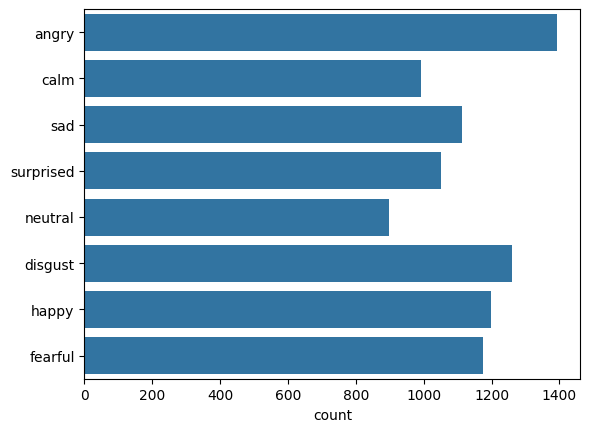

In [517]:
sns.countplot(Y)

> Still some imbalance in the data since different emotions tend to take up different amounts of time to express

In [518]:
classes = np.unique(Y)

In [519]:
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes=classes, y=Y)

In [520]:
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

In [521]:
onehot_enc = tf.keras.utils.to_categorical([i for i in range(len(classes))])

In [522]:
onehot_map = {classes: encoding for classes, encoding in zip(classes, onehot_enc)}

In [523]:
print(onehot_map)

{'angry': array([1., 0., 0., 0., 0., 0., 0., 0.]), 'calm': array([0., 1., 0., 0., 0., 0., 0., 0.]), 'disgust': array([0., 0., 1., 0., 0., 0., 0., 0.]), 'fearful': array([0., 0., 0., 1., 0., 0., 0., 0.]), 'happy': array([0., 0., 0., 0., 1., 0., 0., 0.]), 'neutral': array([0., 0., 0., 0., 0., 1., 0., 0.]), 'sad': array([0., 0., 0., 0., 0., 0., 1., 0.]), 'surprised': array([0., 0., 0., 0., 0., 0., 0., 1.])}


In [524]:
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, [onehot_map[Y] for Y in Y], test_size=0.1) # 10% - test data size

In [525]:
input_shape = np.array(X_train).shape
print(input_shape)
print(np.expand_dims(X_train, -1).shape[1:])

(8171, 32, 67)
(32, 67, 1)


In [526]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=np.expand_dims(X_train, -1).shape[1:]))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
model.add(tf.keras.layers.Conv2D(64, (3,3), activation='relu', strides=(1,1), padding='same'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same'))
model.add(tf.keras.layers.MaxPool2D((2,2)))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

In [527]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_7           │ (None, 32, 67, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 32, 67, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 32, 67, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 67, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 32, 67, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 16, 33, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 67584)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 67584)          │       270,336 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 128)            │     8,650,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 8)              │           520 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,078,924 (34.63 MB)

 Trainable params: 8,943,754 (34.12 MB)

 Non-trainable params: 135,170 (528.01 KB)

In [568]:
import time, datetime
timestamp_str = '-'.join(str(datetime.datetime.fromtimestamp(time.time())).split())
print(f'../models/emvoia-{timestamp_str}.keras')

../models/emvoia-2024-12-05-10:55:06.694886.keras


In [567]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(f'../models/emvoia-{timestamp_str}.keras', monitor='val_acc', verbose=1, mode='max', save_best_only=True, save_weights_only=False)

In [529]:
history = model.fit(np.array(X_train), np.array(Y_train), epochs=10, batch_size=32, verbose=1, class_weight=class_weights, validation_split=0.15, callbacks=[checkpoint])
model.save('models/emvoia.keras')

Epoch 1/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 602ms/step - acc: 0.2240 - loss: 2.0233
Epoch 1: val_acc improved from -inf to 0.21207, saving model to models/emvoia.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 137s 619ms/step - acc: 0.2242 - loss: 2.0228 - val_acc: 0.2121 - val_loss: 1.9735
Epoch 2/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 595ms/step - acc: 0.3588 - loss: 1.6987
Epoch 2: val_acc improved from 0.21207 to 0.31729, saving model to models/emvoia.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 133s 612ms/step - acc: 0.3589 - loss: 1.6986 - val_acc: 0.3173 - val_loss: 1.8073
Epoch 3/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 612ms/step - acc: 0.4976 - loss: 1.3852
Epoch 3: val_acc did not improve from 0.31729
218/218 ━━━━━━━━━━━━━━━━━━━━ 137s 628ms/step - acc: 0.4976 - loss: 1.3852 - val_acc: 0.2838 - val_loss: 2.0822
Epoch 4/10
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - acc: 0.6310 - loss: 1.0451
Epoch 4: val_acc improved from 0.31729 to 0.46656, saving model to models/emvoia.keras
218/218 ━━━━━━━━━━━━━━━━━━━━ 14

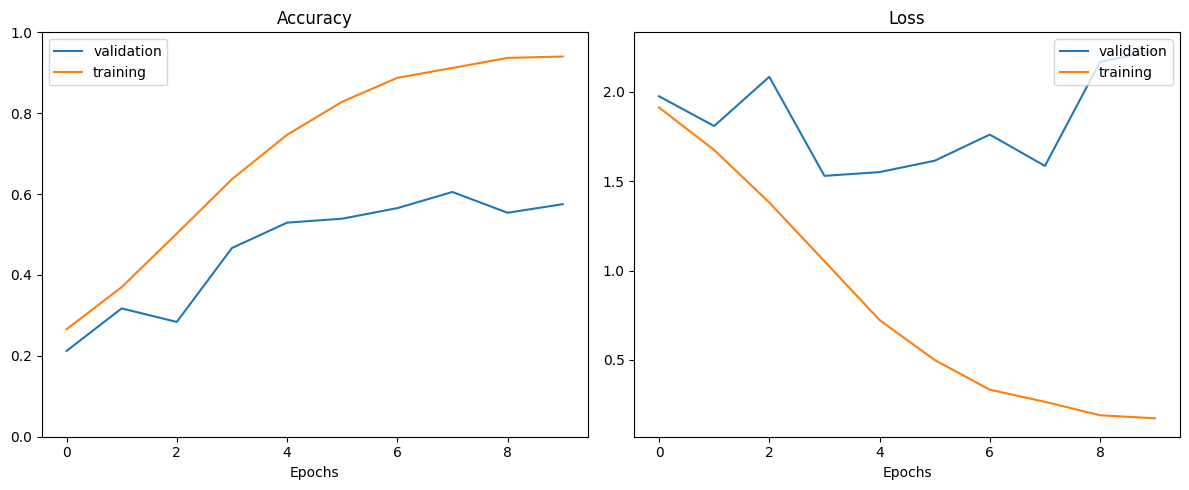

In [530]:
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True)
fig.set_size_inches(12, 5)

ax[0].set(title='Accuracy', xlabel='Epochs')
ax[1].set(title='Loss', xlabel='Epochs')

plt.sca(ax[0])
plt.ylim(0, 1)

val_acc = ax[0].plot(history.history['val_acc'], label='validation')
train_acc = ax[0].plot(history.history['acc'], label='training')

val_loss = ax[1].plot(history.history['val_loss'], label='validation')
train_loss = ax[1].plot(history.history['loss'], label='training')

ax[0].legend(loc='upper left')
ax[1].legend(loc='upper right')

fig.tight_layout()

## Test

In [544]:
def onehot_to_emotion(array):
    return list(onehot_map)[np.argmax(array)]

In [545]:
def predict(input):
    return model.predict(np.expand_dims(input, axis=0), verbose=0)

In [546]:
confusion_matrix_counter = np.matrix([[0 for i in range(len(onehot_map))] for i in range(len(onehot_map))])

In [581]:
for i in tqdm(range(len(X_test)), desc='Predicting test labels'):
    x, y = np.argmax(Y_test[i]), np.argmax(predict(X_test[i]))
    confusion_matrix_counter[x, y] += 1

Predicting test labels:   0%|          | 0/908 [00:00<?, ?it/s]

In [589]:
confusion_matrix = pd.DataFrame(confusion_matrix_counter / confusion_matrix_counter.sum(axis=1), columns=classes, index=classes)

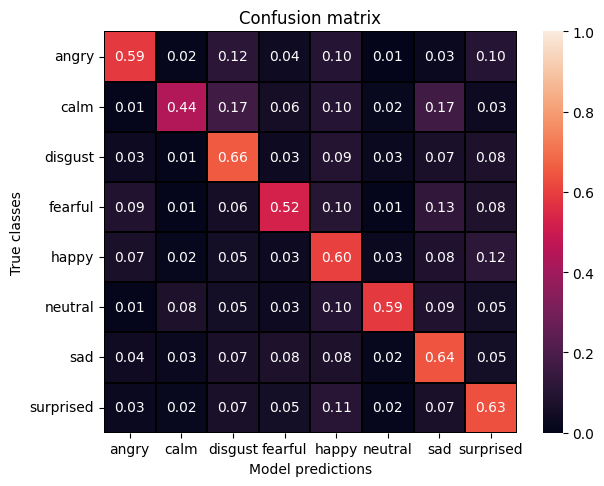

In [624]:
ax = sns.heatmap(pd.DataFrame(confusion_matrix, columns=classes, index=classes), annot=True, vmin=0, vmax=1, fmt='.2f', linewidths=0.1, linecolor='black')
plt.ylabel('True classes')
plt.xlabel('Model predictions')
plt.tight_layout()
_ = ax.set(title='Confusion matrix')